In [1]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
test = pd.read_csv('test.csv', dtype={'id': np.int16})

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<AxesSubplot:xlabel='target', ylabel='count'>

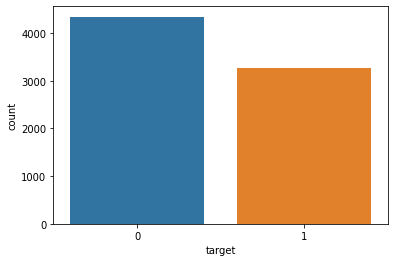

In [4]:
sns.countplot(train["target"])

Text(0, 0.5, 'Distribution')

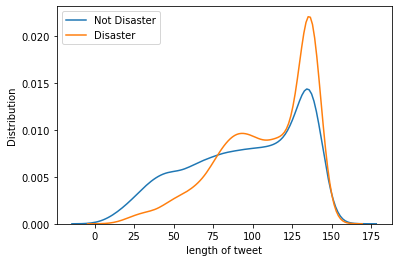

In [5]:
sns.distplot([len(x) for x in train[train["target"] == 0]["text"]], label = "Not Disaster", hist = False)
sns.distplot([len(x) for x in train[train["target"] == 1]["text"]], label = "Disaster", hist = False)
plt.xlabel("length of tweet")
plt.ylabel("Distribution")

There are more non-disaster tweets and disaster tweets are generally longer

In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train.isnull().sum()/train.shape[0]

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [8]:
test.isnull().sum()/test.shape[0]

id          0.000000
keyword     0.007968
location    0.338645
text        0.000000
dtype: float64

In [9]:
wd_count = train[["keyword","target"]].groupby("keyword").agg({"keyword":len, "target":sum})
wd_count["not_target"] = wd_count["keyword"] - wd_count["target"]
wd_count = wd_count.rename(columns = {"keyword":"count"})
wd_count = wd_count.reset_index()
wd_count.describe()

,count,target,not_target
count,221.000000,221.000000,221.000000
mean,34.171946,14.610860,19.561086
std,4.786091,9.696891,9.699209
min,9.000000,0.000000,0.000000
25%,33.000000,6.000000,12.000000
50%,35.000000,13.000000,20.000000
75%,37.000000,22.000000,28.000000
max,45.000000,39.000000,40.000000


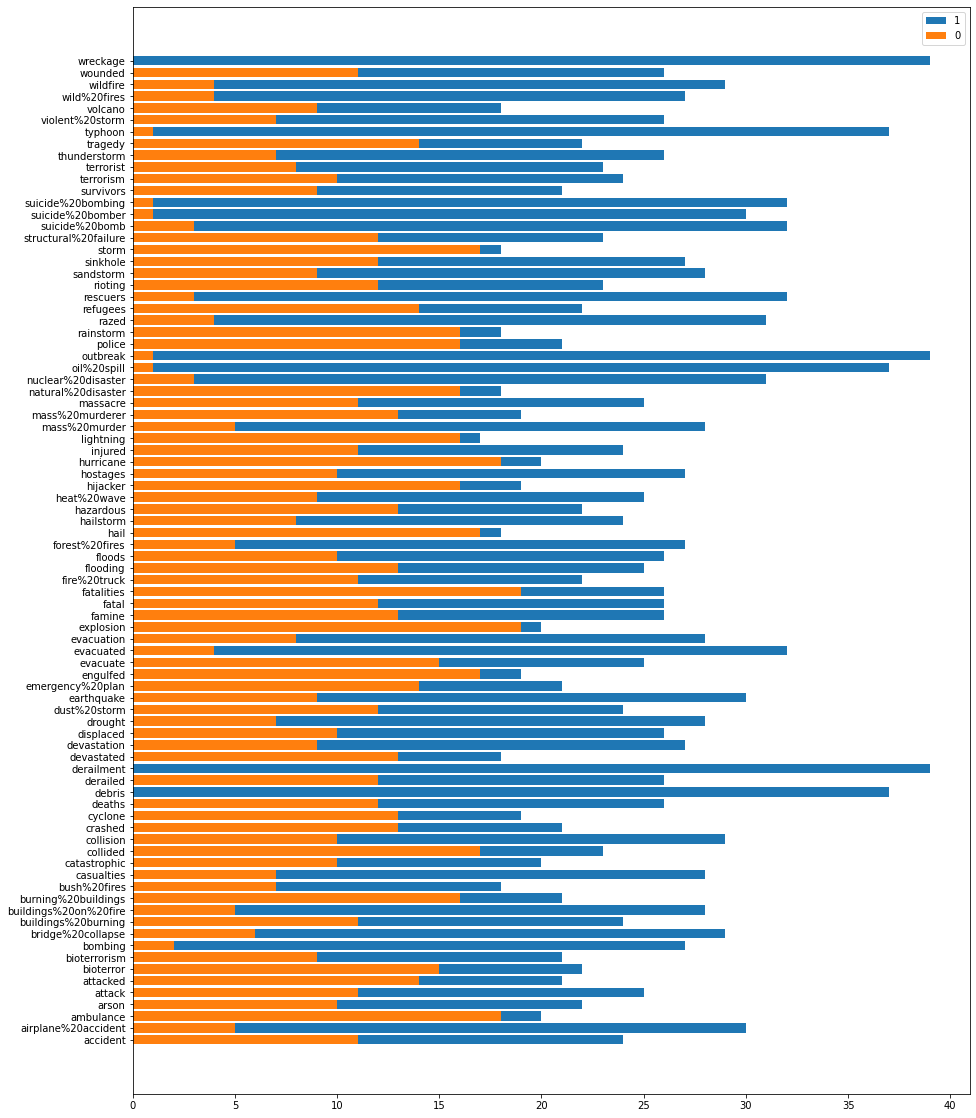

In [10]:
top_words = wd_count[wd_count["count"]>=20]
top_disaster_words = top_words[top_words["target"] >top_words["not_target"] ]
top_non_disaster_words = top_words[top_words["target"] <top_words["not_target"] ]
plt.figure(figsize = (15,20))
ax = plt.barh(top_disaster_words ["keyword"],top_disaster_words ["target"],label = 1)
plt.barh(top_disaster_words ["keyword"],top_disaster_words ["not_target"],label = 0)
#plt.xticks(rotation=90)
plt.legend()

Top keywords with more rows belonging to true disaster tweets, some of them are 100% disaster.

### Using vectorizer and logistic regression

In [11]:
vectorizer = feature_extraction.text.CountVectorizer()
train_vec = vectorizer.fit_transform(train["text"])

In [12]:
y = train["target"]

In [13]:
test_vec = vectorizer.transform(test["text"])

In [14]:
model = linear_model.LogisticRegression()


In [15]:
X_train, X_test, y_train,y_test = model_selection.train_test_split(train_vec, y,test_size=0.2)

In [16]:
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
preds = model.predict(X_test)
preds

array([0, 0, 1, ..., 1, 1, 0], dtype=int8)

In [18]:
sum(preds == y_test)/len(preds)

0.7997373604727511

In [19]:
model_selection.cross_val_score(model, train_vec, y, cv=3, scoring="f1")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.63952866, 0.61386139, 0.6848095 ])

In [20]:
model_selection.cross_val_score(model, X_train, y_train, cv=3, scoring="f1")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.75124378, 0.73846154, 0.73980815])

In [21]:
submission1 = pd.DataFrame({"id":test["id"],"target":model.predict(test_vec)})
submission1.to_csv("submission.csv",index=False)

In [22]:
submission1

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
preds = rf.predict(X_test)
sum(preds == y_test)/len(preds)

0.7708470124753776

In [26]:
model_selection.cross_val_score(rf, X_train, y_train, cv=3, scoring="f1")

array([0.66100495, 0.65165376, 0.66666667])

In [27]:
train["text"].str.findall("attack").apply(lambda x: len(x))

0       0
1       0
2       0
3       0
4       0
       ..
7608    0
7609    0
7610    0
7611    0
7612    0
Name: text, Length: 7613, dtype: int64

Random Forest is worse than logistic regression in terms of text classification

### Using created features

In [28]:
import re

In [29]:
top_target_words = list(top_disaster_words["keyword"])
top_common_words = list(top_non_disaster_words["keyword"])
top_target_counts = []
for word in top_target_words:
    word_freq = train["text"].str.findall(word).apply(lambda x: len(x))
    train[word] = word_freq
for word in top_common_words:
    word_freq = train["text"].str.findall(word).apply(lambda x: len(x))
    train[word] = word_freq

In [30]:
len_text_train = [len(x) for x in train["text"]]
train["length"] = len_text_train
train["capital"] = [len(re.findall("[A-Z]", x)) for x in train["text"]]
train['tag'] = [len(re.findall("#", x)) for x in train["text"]]
train['punc'] = [len(re.findall("[,.;?)(]", x)) for x in train["text"]]

In [31]:
X = train.drop(["id","keyword","location","text","target"],axis=1)
X_train1, X_test1, y_train1,y_test1 = model_selection.train_test_split(X, y,test_size=0.3)

In [32]:
model1 = linear_model.LogisticRegression()
model1.fit(X_train1, y_train1)
preds1 = model1.predict(X_test1)
sum(preds1 == y_test1)/len(preds1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6922066549912435

In [33]:
for word in top_target_words:
    word_freq = test["text"].str.findall(word).apply(lambda x: len(x))
    test[word] = word_freq

In [34]:
model_selection.cross_val_score(model1, X, y, cv=3, scoring="f1")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.48419865, 0.48056537, 0.54076802])

### Deep Learning on Text Column

In [35]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding

In [36]:
vocab_size = 20000
train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
test = pd.read_csv('test.csv', dtype={'id': np.int16})
texts = train["text"]

In [37]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [38]:
np.mean(len_text_train), np.std(len_text_train)

(101.03743596479706, 33.779106292253026)

In [39]:
max_length = 100
data = pad_sequences(sequences, maxlen=max_length)
from keras.utils import to_categorical
labels = to_categorical(y)

In [40]:
labels.shape

(7613, 2)

In [41]:
import os
embeddings_index = {} 
f = open(os.path.join('../../../Downloads/glove.6B', 'glove.6B.100d.txt')) 
for line in f:
    values = line.split()
    word = values[0] 
    embedding = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = embedding 
f.close()

In [42]:
all_embs = np.stack(embeddings_index.values())
emb_mean = all_embs.mean() # Calculate mean
emb_std = all_embs.std() # Calculate standard deviation
emb_mean,emb_std

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(0.004451992, 0.4081574)

In [45]:
embedding_dim = 100
word_index = tokenizer.word_index
words_num = min(vocab_size, len(word_index)) # How many words are there actually

embedding_matrix = np.zeros((words_num, embedding_dim))

# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word_index.items():
    if i >= vocab_size: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [46]:
model = Sequential()
model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    input_length=max_length, 
                    weights = [embedding_matrix], 
                    trainable = False))
model.add(LSTM(128))
model.add(Dense(64))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 2,125,634
Trainable params: 125,634
Non-trainable params: 2,000,000
_________________________________________________________________


In [47]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.fit(data,labels,validation_split=0.2,epochs=6)

Epoch 1/6
191/191 [==============================] - 31s 161ms/step - loss: 0.4812 - acc: 0.7768 - val_loss: 0.4529 - val_acc: 0.7846
Epoch 2/6
191/191 [==============================] - 31s 160ms/step - loss: 0.4304 - acc: 0.8082 - val_loss: 0.4549 - val_acc: 0.7945
Epoch 3/6
191/191 [==============================] - 41s 217ms/step - loss: 0.4095 - acc: 0.8233 - val_loss: 0.4319 - val_acc: 0.8096
Epoch 4/6
191/191 [==============================] - 43s 224ms/step - loss: 0.3983 - acc: 0.8276 - val_loss: 0.4367 - val_acc: 0.7991
Epoch 5/6
191/191 [==============================] - 38s 197ms/step - loss: 0.3815 - acc: 0.8411 - val_loss: 0.4558 - val_acc: 0.7945
Epoch 6/6
191/191 [==============================] - 37s 192ms/step - loss: 0.3488 - acc: 0.8521 - val_loss: 0.4520 - val_acc: 0.8089


In [49]:
sequences_test = tokenizer.texts_to_sequences(test["text"]) 
test_data = pad_sequences(sequences_test, maxlen=max_length)

In [50]:
model.predict(test_data)

array([[0.5940305 , 0.4059695 ],
       [0.06955702, 0.930443  ],
       [0.12277172, 0.8772283 ],
       ...,
       [0.06091606, 0.939084  ],
       [0.18711206, 0.8128879 ],
       [0.40103838, 0.5989616 ]], dtype=float32)

LSTM code reference: https://www.kaggle.com/jannesklaas/19-lstm-for-email-classification

### Summary
By using a simple vectorizer matrix, logistic regression can achieve around 80% accuracy, while random forest did not achieve such high accuracy. By extracting some features and use them alone, the accuracy becomes lower. Lastly, LSTM model seems to provide higher accuracy overall. 